# DBScan

### Introduction

Similiar to K-means, DBScan is another very common unsupervised learning method used for clustering. That is, the assignment of the points $X_1$, $X_2$, ..., $X_N$ to the labels $y_1$, $y_2$, ..., $y_k$. DBscan stands for **D**ensity-**b**ased **s**patial **c**lustering of **a**pplications and works by, as stated in the name, considering only the density of the data points in the feature space. Clusters are formed from regions of high density while points located in lower density regions are more likely to be labelled as outliers or "noise" in the context of DBscan. Since DBscan only considers density, it is able to predict clusers of arbitrary shape. This may be contrast to k-means which leans towards more spherical shaped clusters due to its consideration of centroids. When working with datasets like $X$ with $N > 3$ number of features, we do not know what shape our clusters are because we simply cannot visualise them. It is then common practice to employ both k-means and DBscan because,

**(a).** DBscan will perform well if our clusters are arbitrary shaped.

**(b).** K-means on the other had will perform best when the clusters are spherical shaped (or the equivalent higher dimensional analogy)

Let us now create a dataset to cluster,

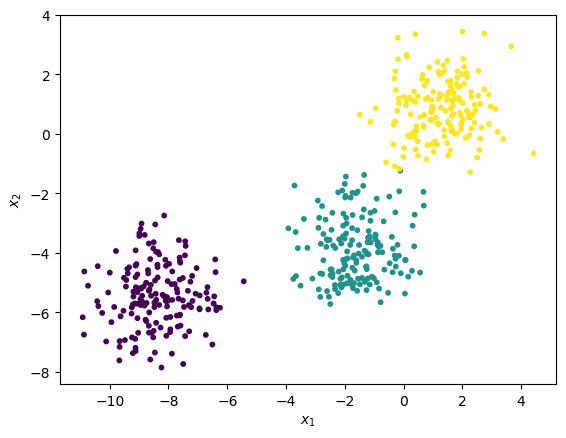

In [71]:
# Importing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Creating dataset,
X, y = make_blobs(n_samples=500, random_state=57)
plt.scatter(X.T[0], X.T[1], s=10, c=y)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

### Theory

The DBscan algorithm can roughly be divided into two parts. In the first part, we assign each point a category label $0, 1, 2$ for _"core"_, _"boundary"_ and _"noise"_ respectively. The criteria for these classications are as follows,

(a). **Core Points**: A datapoint $X_j$ is said to be a core point if it has at least $N_{min}$ within a distance $\epsilon$ from it in feature space. Note that our distance metric is assumed to be the Euclidean norm.

(b). **Boundary Points**: $X_j$ is considered a boundary point if it has a least one neigbouring datapoint within a distance $\epsilon$ from it, but less than $N_{min}$ neighbouring datapoints.

(c). **Noise Points**: To assigned as noise, a datapoint $X_j$ must have no neigbouring datapoints within a distance $\epsilon$ from it.

$\epsilon$ and $N_{min}$ are the only hyperparameters needed for the core algorithm of DBscan. Let us implement this first step below,

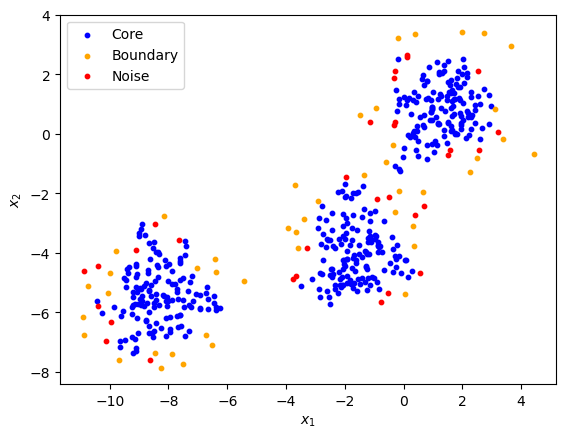

In [83]:
# Helper functions,
def compute_dist(X1, X2):
    """Computes the Euclidean norm between the datapoints X_1 and X_2 in feature space."""
    return np.sqrt(np.sum((X1 - X2)**2))

def compute_nearest_neighbours(Xi, X, epsilon):
    """Returns the indices of the neighbouring data points of a given point X_i with a distance epsilon from its location."""

    # Initialising empty distances array,
    distances = np.empty(shape=len(X))

    # Computing distance to each datapoint in the dataset,
    for i, datapoint in enumerate(X):
        dist = compute_dist(datapoint, Xi)
        distances[i] = dist

    # Finding all datapoints within epsilon,
    neighbours = np.where(distances < epsilon)[0]

    return neighbours

# HYPERPARAMERS,
EPSILON = 0.5
MIN_SAMPLES = 3
MIN_CLUSTER_SIZE = 3

# Initialising array for category labels,
cat_labels = np.empty(shape=len(X))

# Categorising points,
for i, datapoint in enumerate(X):

    # Computing the number of neighbours,
    n_neighbours = len(compute_nearest_neighbours(Xi=datapoint, X=X, epsilon=EPSILON))

    # Assigning category of core, boundary or noise point,
    if n_neighbours > MIN_SAMPLES:
        cat_labels[i] = 0
    elif n_neighbours < MIN_SAMPLES and n_neighbours != 0:
        cat_labels[i] = 1
    else:
        cat_labels[i] = 2

# Plotting, 
colors = ["blue", "orange", "red"]
labels = ["Core", "Boundary", "Noise"]

for category in [0, 1, 2]:
    idx = cat_labels == category
    plt.scatter(X[idx, 0], X[idx, 1], s=10, c=colors[int(category)], label=labels[int(category)])

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

In the second part, we assign each core point to a cluster. We begin by growing a cluster from the first core point, which serves as the initial seed. In the growth algorithm, we consider all other core points within a distance $\epsilon$ of the seed during the first iteration ($t = 0$). These core points are assigned the same cluster label as the seed, thereby becoming part of the same cluster. In the next iteration ($t = 1$), we repeat this process for the points that were added to the cluster in the previous iteration. That is, for each new cluster point, we again search for nearby core points within $\epsilon$ and assign them the cluster label. This iterative process continues until no new core points can be added to the cluster—i.e., all reachable core points within $\epsilon$ of the cluster have been exhausted. Let us implement these steps in code,

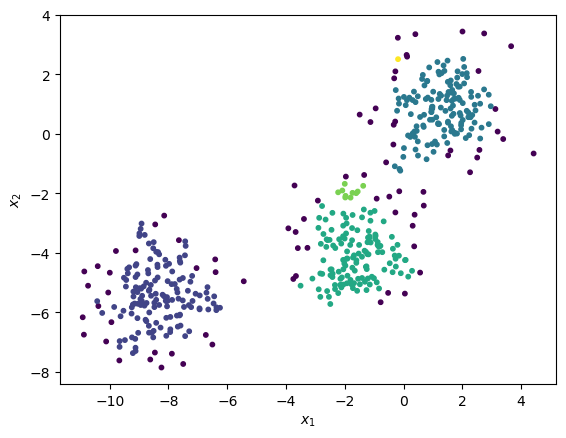

In [74]:
# Initialising cluser ID,
cluster_id = 1
unique_ids = [0, cluster_id]

# Initialising array of cluster labels,
cluster_labels = np.zeros(shape=len(cat_labels), dtype=int)

# Indices of core labels,
core_idxs = np.where(cat_labels == 0)[0]

# Keeping track of visted core points,
visited_points = set()

for core_idx in core_idxs:

    if core_idx in visited_points:
        continue # <-- Skip to next core_idx

    # Creating seed,
    queue = [core_idx]

    # Cluster growth algorithm,
    while queue:

        # Extracting index,
        current_idx = queue.pop()

        # Checking if point has been visted before,
        if current_idx in visited_points:
            continue # <-- Skip this point in the queue
        
        # Marking point as visited,
        visited_points.add(current_idx)

        # Adding point to the cluser,
        cluster_labels[current_idx] = cluster_id

        # Compute neighbours of current point,
        neighbours_idxs = compute_nearest_neighbours(Xi=X[current_idx], X=X, epsilon=EPSILON)

        # Keep only unvisited core neighbours,
        core_neighbours = [idx for idx in neighbours_idxs if cat_labels[idx] == 0 and idx not in visited_points]

        # Adding neighbours to the queue,
        queue.extend(core_neighbours)

    # Udpating cluster ID,
    cluster_id += 1
    unique_ids.append(cluster_id)

# Plotting,
plt.scatter(X.T[0], X.T[1], s=10, c=cluster_labels)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Next, we must decide how to assign the remaining boundary points to clusters. In our implementation, each boundary point is assigned to the cluster that has the largest number of points within a distance $\epsilon$ from it. In other words, we count the number of neighboring points (within $\epsilon$) belonging to each cluster and assign the boundary point to the cluster with the highest count. Additionally, we impose a minimum cluster size threshold. Any cluster with fewer than $T_C$ points is considered too small to be valid, and all of its points—including core and boundary points—are reclassified as noise. Writing this in code,

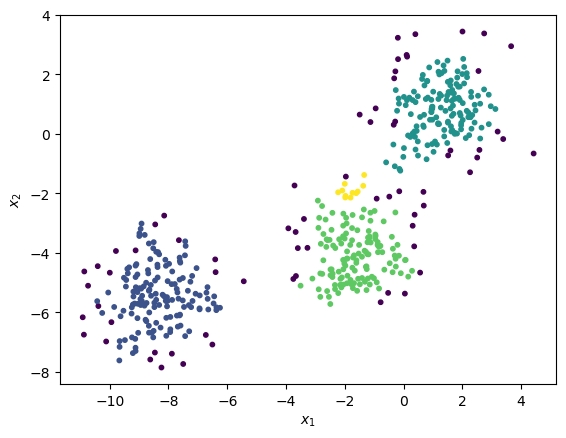

In [75]:
# Extracting all boundary points,
boundary_idxs = np.where(cat_labels == 1)[0]

# Looping over boundary points,
for boundary_idx in boundary_idxs:
    neighbours_idxs = compute_nearest_neighbours(Xi=X[boundary_idx], X=X, epsilon=EPSILON)
    neighbours_ids = cluster_labels[neighbours_idxs]
    cluster_ids = neighbours_ids[neighbours_ids != 0] # <--- Removing all noise or unclustered points

    # Case when the boundary point is close to cluster points,
    if len(cluster_ids) != 0:
        majority_label = np.bincount(cluster_ids).argmax()
        cluster_labels[boundary_idx] = majority_label
    # Case when the boundary point is not close to any cluster point, 
    else:
        cluster_labels[boundary_idx] = 0 # <-- Point is marker as an outlier

# Removing clusers which do not meet the size requirement,
for cluster_id in unique_ids:

    # Skipping noise points,
    if cluster_id == 0:  
        continue

    # Computing number of points within the cluster,
    cluster_idxs = np.where(cluster_labels == cluster_id)[0]
    n_cluster_points = len(cluster_idxs)

    # Case when the cluser is too small,
    if n_cluster_points < MIN_CLUSTER_SIZE:
        cluster_labels[cluster_idxs] = 0  # <-- Reassigning cluser points to noise

# Plotting,
plt.scatter(X.T[0], X.T[1], s=10, c=cluster_labels)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

### Model

Now we package our DBScan algorithm as a class for future usage,

In [86]:
class DBScan():

    def __init__(self, epsilon, min_samples, min_cluster_size):
        """Constructor method."""

        # Assigning hyperparameters,
        self.epsilon, self.min_samples, self.min_cluster_size = epsilon, min_samples, min_cluster_size

        # Placeholders for class attributes,
        self.cluster_labels = None

    def fit(self, X):

        # Initialising array for category labels,
        cat_labels = np.empty(shape=len(X))

        # Categorising points,
        for i, datapoint in enumerate(X):

            # Computing the number of neighbours,
            n_neighbours = len(self._compute_nearest_neighbours(Xi=datapoint, X=X, epsilon=self.epsilon))

            # Assigning category of core, boundary or noise point,
            if n_neighbours > self.min_samples:
                cat_labels[i] = 0
            elif n_neighbours < self.min_samples and n_neighbours != 0:
                cat_labels[i] = 1
            else:
                cat_labels[i] = 2

        # Initialising cluser ID,
        cluster_id = 1
        unique_ids = [0, cluster_id]

        # Initialising array of cluster labels,
        cluster_labels = np.zeros(shape=len(cat_labels), dtype=int)

        # Indices of core labels,
        core_idxs = np.where(cat_labels == 0)[0]

        # Keeping track of visted core points,
        visited_points = set()

        for core_idx in core_idxs:

            if core_idx in visited_points:
                continue # <-- Skip to next core_idx

            # Creating seed,
            queue = [core_idx]

            # Cluster growth algorithm,
            while queue:

                # Extracting index,
                current_idx = queue.pop()

                # Checking if point has been visted before,
                if current_idx in visited_points:
                    continue # <-- Skip this point in the queue
                
                # Marking point as visited,
                visited_points.add(current_idx)

                # Adding point to the cluser,
                cluster_labels[current_idx] = cluster_id

                # Compute neighbours of current point,
                neighbours_idxs = self._compute_nearest_neighbours(Xi=X[current_idx], X=X, epsilon=self.epsilon)

                # Keep only unvisited core neighbours,
                core_neighbours = [idx for idx in neighbours_idxs if cat_labels[idx] == 0 and idx not in visited_points]

                # Adding neighbours to the queue,
                queue.extend(core_neighbours)

            # Udpating cluster ID,
            cluster_id += 1
            unique_ids.append(cluster_id)

        # Extracting all boundary points,
        boundary_idxs = np.where(cat_labels == 1)[0]

        # Looping over boundary points,
        for boundary_idx in boundary_idxs:
            neighbours_idxs = self._compute_nearest_neighbours(Xi=X[boundary_idx], X=X, epsilon=self.epsilon)
            neighbours_ids = cluster_labels[neighbours_idxs]
            cluster_ids = neighbours_ids[neighbours_ids != 0] # <--- Removing all noise or unclustered points

            # Case when the boundary point is close to cluster points,
            if len(cluster_ids) != 0:
                majority_label = np.bincount(cluster_ids).argmax()
                cluster_labels[boundary_idx] = majority_label
            # Case when the boundary point is not close to any cluster point, 
            else:
                cluster_labels[boundary_idx] = 0 # <-- Point is marker as an outlier

        # Removing clusers which do not meet the size requirement,
        for cluster_id in unique_ids:

            # Skipping noise points,
            if cluster_id == 0:  
                continue

            # Computing number of points within the cluster,
            cluster_idxs = np.where(cluster_labels == cluster_id)[0]
            n_cluster_points = len(cluster_idxs)

            # Case when the cluser is too small,
            if n_cluster_points < self.min_cluster_size:
                cluster_labels[cluster_idxs] = 0  # <-- Reassigning cluser points to noise

        # Storing cluster labels,
        self.cluster_labels = cluster_labels

        # Returning cluster labels,
        return cluster_labels

    @staticmethod
    def _compute_dist(X1, X2):
        """Computes the Euclidean norm between the datapoints X_1 and X_2 in feature space."""
        return np.sqrt(np.sum((X1 - X2)**2))

    @staticmethod
    def _compute_nearest_neighbours(Xi, X, epsilon):
        """Returns the indices of the neighbouring data points of a given point X_i with a distance epsilon from its location."""

        # Initialising empty distances array,
        distances = np.empty(shape=len(X))

        # Computing distance to each datapoint in the dataset,
        for i, datapoint in enumerate(X):
            dist = compute_dist(datapoint, Xi)
            distances[i] = dist

        # Finding all datapoints within epsilon,
        neighbours = np.where(distances < epsilon)[0]

        return neighbours

Writing the boilerplate code,

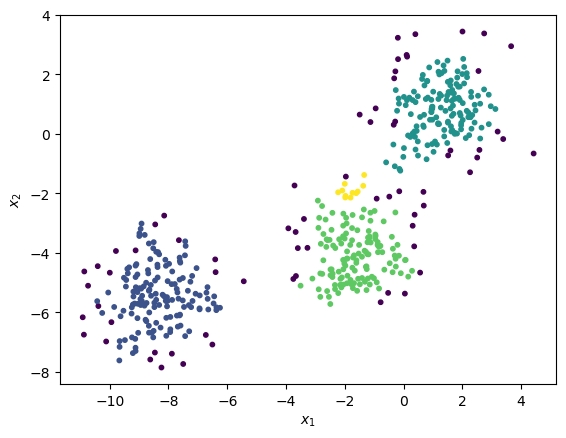

In [88]:
# Creating dataset,
X, y = make_blobs(n_samples=500, random_state=57)

# HYPERPARAMERS,
EPSILON = 0.5
MIN_SAMPLES = 3
MIN_CLUSTER_SIZE = 3

# Performing DBScan,
DB = DBScan(epsilon=EPSILON, min_samples=MIN_SAMPLES, min_cluster_size=MIN_CLUSTER_SIZE)
cluster_labels = DB.fit(X)

# Plotting,
plt.scatter(X.T[0], X.T[1], s=10, c=cluster_labels)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

# References

https://www.youtube.com/watch?v=RDZUdRSDOok

https://www.youtube.com/watch?v=D66-iuQ-4O8